In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
%matplotlib inline
plt.rcParams['font.sans-serif'] = ['SimHei'] # 指定默认字体
plt.rcParams['axes.unicode_minus'] = False # 解决保存图像时负号‘-’显示为方块的问题
import warnings
warnings.filterwarnings("ignore") # 忽略警告

In [2]:
gen = pd.read_csv('./titanic/gender_submission.csv')
test = pd.read_csv('./titanic/test.csv')
train = pd.read_csv('./titanic/train.csv')

In [3]:
# pclass 1:高等舱 2:中等舱 3:低等舱 # Age:年龄 .5格式表示预测 # sibsp:兄弟姐妹/配偶数
# Parch:父母/孩子个数 # Ticket:票号 # Fare:票价 # Cabin:舱号  # embarked:登船港口

### 数据清洗

In [4]:
len(train)

891

In [31]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### 构建分类模型

#### 标准化, 随机森林筛选

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split # 分数据集
import sklearn.ensemble as ensemble # 随机森林
# 随机森林筛选
def var_chooce(x_data,y_data,yuzhi=0.01):
    '''
    yuzhi: 阈值，重要性大于该阈值的变量选入模型
    '''
    rfc = ensemble.RandomForestClassifier(random_state=100) # criterion='entropy', n_estimators=3,max_features=0.5,min_samples_split=5,
    rfc_model = rfc.fit(x_data,y_data)
    rfc_fi = pd.DataFrame()
    rfc_fi['features'] = list(x_data.columns)
    rfc_fi['importance'] = list(rfc_model.feature_importances_)
    rfc_fi = rfc_fi.set_index('features',drop=True)
    # plt.figure(dpi=150)
    var_sort = rfc_fi.sort_values('importance',ascending=False)
    var_sort = var_sort.iloc[:20].sort_values('importance',ascending=True)
    plt.xticks(rotation=90)
    plt.barh(var_sort.index[:20],var_sort.importance[:20])
    plt.title('变量的重要性')
    # 以2%作为选取变量的阈值,（之后要与iv取并集）
    var_x = list(var_sort.importance[var_sort.importance>yuzhi].index)
    # print(var_x)
    return x_data[var_x]

 # 标准化
def biaozhun(x_data,y_data,var=True):
    '''
    var: 变量是否需要随机森林筛选，True，是，否则直接把行放上去，eg: var = x1.columns
    '''
    columns = []                         # 提取非虚拟变量，虚拟变量不需要标准化
    for column in x2:
        a = set(x2[column].value_counts().index)
        if (a <= {0,1}) == False:       # 用该列的值是否为1或0来判断是否为虚拟变量
            columns.append(column)
        
    s1=StandardScaler()
    s1.fit(x_data.loc[:,columns])
    x_data.loc[:,columns] = s1.transform(x_data.loc[:,columns])
    if var == True:
        x_data = var_chooce(x_data,y_data)
    else:
        x_data = x_data[var]
    x_train,x_test,y_train,y_test = train_test_split(x_data,y_data,test_size=0.3,random_state=100)
    return x_train,y_train,x_test,y_test

#### roc

In [7]:
def draw_roc(name,fpr_test,tpr_test,fpr_train,tpr_train): # 生成ROC曲线
    plt.figure(dpi=150,figsize=(3,3))
    plt.plot(fpr_test,tpr_test,'b:',label=f'测试集AUC={round(metrics.auc(fpr_test,tpr_test),4)}')
    plt.plot(fpr_train,tpr_train,'r-.',label=f'训练集AUC={round(metrics.auc(fpr_train,tpr_train),4)}')
    plt.legend();plt.title(f'ROC曲线-{name}');plt.xlabel('假正率');plt.ylabel('真正率')
    # plt.grid()
    plt.plot([0, 1], [0, 1], 'k--',linewidth = 0.5)

#### 混淆矩阵

In [8]:
def hxjz(model,x_train,y_train,x_test,y_test,yuzhi=0.5): # 函数-生成混淆矩阵,yuzhi=阈值
    '''
    yuzhi: 阈值
    '''
    test = pd.DataFrame(model.predict_proba(x_test)[:,1],columns=['pre'])
    test['true'] = y_test.values
    test['pre2'] = test['pre'].apply(lambda x: 1 if x>=yuzhi else 0)
    train = pd.DataFrame(model.predict_proba(x_train)[:,1],columns=['pre'])
    train['true'] = y_train.values
    train['pre2'] = train['pre'].apply(lambda x: 1 if x>=yuzhi else 0)

    hx = pd.DataFrame()
    hx['1'] = ['训练集','训练集','测试集','测试集']
    hx['2'] = ['预测为0','预测为1','预测为0','预测为1']
    hx.loc[0,'实际为0'] = (train[train['true']==0]['pre2'] == train[train['true']==0]['true']).agg(sum)
    hx.loc[1,'实际为0'] = len(train[train['true']==0]) - hx.loc[0,'实际为0']
    hx.loc[0,'实际为1'] = (train[train['true']==1]['pre2'] != train[train['true']==1]['true']).agg(sum)
    hx.loc[1,'实际为1'] = (train[train['true']==1]['pre2'] == train[train['true']==1]['true']).agg(sum)

    hx.loc[2,'实际为0'] = (test[test['true']==0]['pre2'] == test[test['true']==0]['true']).agg(sum)
    hx.loc[3,'实际为0'] = len(test[test['true']==0]) - hx.loc[2,'实际为0']
    hx.loc[2,'实际为1'] = (test[test['true']==1]['pre2'] != test[test['true']==1]['true']).agg(sum)
    hx.loc[3,'实际为1'] = (test[test['true']==1]['pre2'] == test[test['true']==1]['true']).agg(sum)

    hx.set_index(['1','2'],inplace=True)

    hx.loc['训练集','预测准确率'] = format((train['pre2'] == train['true']).agg(sum)/len(train),'.2%')
    hx.loc['测试集','预测准确率'] = format((test['pre2'] == test['true']).agg(sum)/len(test),'.2%')

    hx.loc['训练集','违约企业预测准确率'] = format(hx['实际为1'][1]/(train.true==1).agg(sum),'.2%')
    hx.loc['测试集','违约企业预测准确率'] = format(hx['实际为1'][3]/(test.true==1).agg(sum),'.2%')
    return hx

#### 优化参数，得到模型

In [9]:
from sklearn.linear_model import LogisticRegression as LR # 逻辑回归
from sklearn import svm                                   # SVM
from sklearn.neural_network import MLPClassifier          # 神经网络
from sklearn.ensemble import RandomForestClassifier       # 随机森林
from sklearn.tree import DecisionTreeClassifier           # 决策树
from sklearn.naive_bayes import GaussianNB                # 朴素贝叶斯
from sklearn.model_selection import GridSearchCV
import sklearn.metrics as metrics # 绘制ROC曲线
def best_params(name,x_train,y_train,random_state=100): # 自动寻找最优参数
    '''
    name: 模型名称
    random_state: 随机数种子
    '''
    # 参数设置
    model_dic1 = {'逻辑回归':LR(), 'SVM':svm.SVC(),'神经网络':MLPClassifier(),'随机森林':RandomForestClassifier(),
                  '决策树':DecisionTreeClassifier(),'朴素贝叶斯':GaussianNB()}
    params_dic = {'逻辑回归':{'C':[0.0001, 1, 100, 1000],'max_iter':[1, 10, 100, 500],'class_weight':['balanced', None],'solver':['liblinear','sag','lbfgs','newton-cg']},
                  'SVM':[{'kernel': ['linear'], 'C': [1, 10, 100, 100]},{'kernel': ['poly'], 'C': [1], 'degree': [2, 3]},{'kernel': ['rbf'], 'C': [1, 10, 100, 100], 'gamma':[1, 0.1, 0.01, 0.001]}],
                  '神经网络':[{'activation':['identity','logistic','tanh','relu'],'solver': ['sgd','lbfgs','adam'], 'learning_rate': ['constant'], "learning_rate_init" : [0.001, 0.01, 0.05, 0.1]},{"learning_rate_init" : [0.001, 0.01, 0.05, 0.1]}],
                  '随机森林':{'max_depth':[1,2,3,4,5]},
                  '决策树':{'criterion':['gini','entropy'],'max_depth':[1,2,3],'min_samples_leaf':[1,2,3,5,10],'min_impurity_decrease':[0,0.05,0.1,0.2,0.5]},
                  '朴素贝叶斯':{}} # 贝叶斯不调参数
    
    params = params_dic[name]
    model = model_dic1[name]
        
    clf1 = GridSearchCV(model,param_grid=params,cv=10)
    clf1.fit(x_train,y_train)
    print(clf1.best_params_) # 查看最佳参数组合
    return clf1.best_params_ 

def model_fun(x_train,y_train,x_test,y_test,name='逻辑回归',random_state=100,params=False,roc=False):
    '''
    name: 模型名称 -- ['逻辑回归', 'SVM', '神经网络', '随机森林', '决策树', '朴素贝叶斯']
    random_sate: 随机种子
    params: 是否进行参数优化，费时间。True是；False否；{**} 自定义参数
    roc: 是否导出tpr,fpr,auc # 用来画每个模型的roc曲线
    
    '''

    if params == True:
        params = best_params(name,x_train,y_train,random_state=random_state)
    elif params == False:
        params = {}
    else:
        params = params
        
    model_dic2 = {'逻辑回归':LR, 'SVM':svm.SVC,'神经网络':MLPClassifier,'随机森林':RandomForestClassifier,
                 '决策树':DecisionTreeClassifier,'朴素贝叶斯':GaussianNB}
    
    try:
        if name == 'SVM':       # 打开SVM模型的预测功能
            model = model_dic2[name](**params,probability=True).fit(x_train,y_train)
        elif name == '神经网络' or name == '随机森林':  # 有的模型需要设置种子
            model = model_dic2[name](**params,random_state=random_state).fit(x_train,y_train)
        else:
            model = model_dic2[name](**params).fit(x_train,y_train)
    except:
            print("没有此模型，或者模型名称拼写错误（['逻辑回归', 'SVM', '神经网络', '随机森林', '决策树', '朴素贝叶斯']")
    
    # roc
    fpr_test,tpr_test,th_test = metrics.roc_curve(y_test,model.predict_proba(x_test)[:,1]) # 测试集
    fpr_train,tpr_train,th_train = metrics.roc_curve(y_train,model.predict_proba(x_train)[:,1]) # 训练集
    draw_roc(name,fpr_test,tpr_test,fpr_train,tpr_train)
    
    if roc == True:
        auc = round(metrics.auc(fpr_test,tpr_test),4)
        return model,fpr_test,tpr_test,auc
    return model

#### 交叉验证

In [10]:
from sklearn.model_selection import cross_val_score # 导入交叉验证函数
def jiaocha(model,x_data,y_data,scoring='roc_auc'):
    '''
    model: 分类模型
    scoring: 分数类型
    '''
    metric = cross_val_score(model,x_data,y_data,cv=10,scoring=scoring) # model：要交叉验证的模型 x1：总因变量，y1：总自变量 cv:10折交叉验证，将总数据分成10分挨个进行训练
    print(metric.mean()) # metric就是每一个次训练得到的准确率，打印出准确率的平均值
    return metric # 返回10折交叉验证的10个结果，作图比较

#### 缺失年龄,港口填充

In [11]:
import re
def age_fillna(df):  # 缺失年龄填充函数
    df_all = pd.concat([train,test])
    df.loc[:,'Age_name'] = df.Name.apply(lambda x: re.search(', (.*?). ', x).group(1)) # 正则提取Mr/Mrs...
    df_all.loc[:,'Age_name'] = df_all.Name.apply(lambda x: re.search(', (.*?). ', x).group(1)) # 正则提取Mr/Mrs...
    # 用总的Mr/Mrs/..均值（即train和test的合并均值）填充缺失值
    index = df[df.Age.isna()].Age_name.value_counts().index
    print('各个缺失名称的平均年龄：')
    for i in index:
        if len(df[df.Age.isna()][df.Age_name==i]) == 0:
            raise Exception(print(i,'没有样本来填充'))
        mean = df_all[df_all.Age_name==i].Age.agg(np.mean)
        df.loc[df.Age_name==i,'Age'] = df.loc[df.Age_name==i,'Age'].fillna(mean)
        print(i,':',mean)
    return df

In [12]:
# 年龄填充
df_train = copy.deepcopy(train)
df_train = age_fillna(df_train)
# 港口填充
df_train.loc[:,'Embarked'] = df_train.loc[:,'Embarked'].fillna(df_train.loc[:,'Embarked'].describe().top)

各个缺失名称的平均年龄：
Mr : 32.25215146299484
Miss : 21.774238095238097
Mrs : 36.99411764705882
Master : 5.482641509433963
Dr : 43.57142857142857


#### 数据准备

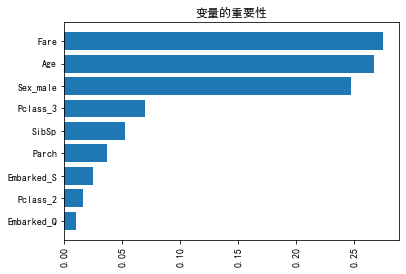

In [13]:
y2 = df_train['Survived']
x2 = df_train[['SibSp','Parch','Age','Fare','Pclass','Sex','Embarked']]
x2 = pd.get_dummies(x2,columns=['Pclass','Sex','Embarked'],drop_first=True)
x2_train,y2_train,x2_test,y2_test = biaozhun(x2,y2)

In [14]:
fpr = [0 for i in range(6)]; tpr = [0 for i in range(6)]; auc=[0 for i in range(6)] # 画每个模型的roc曲线
jiaocha_score = [0 for i in range(6)] # 画每个模型的交叉验证

### 神经网络

0.8706207169736582


实际为0   实际为1   预测准确率 违约企业预测准确率
1   2                                   
训练集 预测为0  357.0   66.0  84.11%    71.67%
    预测为1   33.0  167.0  84.11%    71.67%
测试集 预测为0  145.0   35.0  81.72%    67.89%
    预测为1   14.0   74.0  81.72%    67.89%

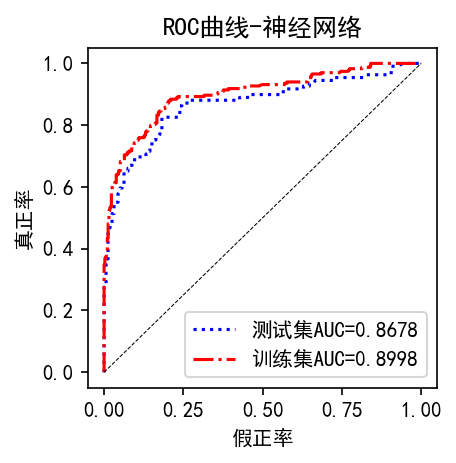

In [15]:
model1,fpr[0],tpr[0],auc[0] = model_fun(x2_train,y2_train,x2_test,y2_test,name='神经网络',roc=True) # 不需要params=True
jiaocha_score[0] = jiaocha(model1,x2,y2) # 交叉验证 1次10折交叉验证
hxjz(model1,x2_train,y2_train,x2_test,y2_test,yuzhi=0.5)

### 逻辑回归

0.8556219902102254


实际为0   实际为1   预测准确率 违约企业预测准确率
1   2                                   
训练集 预测为0  347.0   76.0  80.90%    67.38%
    预测为1   43.0  157.0  80.90%    67.38%
测试集 预测为0  141.0   35.0  80.22%    67.89%
    预测为1   18.0   74.0  80.22%    67.89%

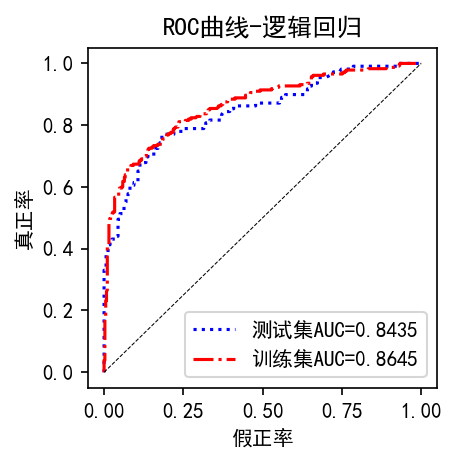

In [16]:
model2,fpr[1],tpr[1],auc[1] = model_fun(x2_train,y2_train,x2_test,y2_test,name='逻辑回归',roc=True)
jiaocha_score[1] = jiaocha(model2,x2,y2) # 交叉验证 50次10折交叉验证
hxjz(model2,x2_train,y2_train,x2_test,y2_test,yuzhi=0.5)

### SVM

0.8533196389666978


实际为0   实际为1   预测准确率 违约企业预测准确率
1   2                                   
训练集 预测为0  356.0   61.0  84.75%    73.82%
    预测为1   34.0  172.0  84.75%    73.82%
测试集 预测为0  143.0   34.0  81.34%    68.81%
    预测为1   16.0   75.0  81.34%    68.81%

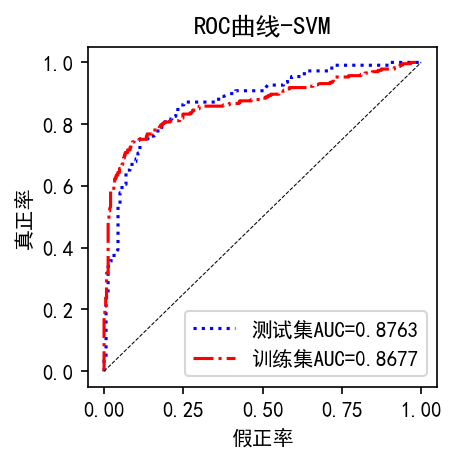

In [17]:
model3,fpr[2],tpr[2],auc[2] = model_fun(x2_train,y2_train,x2_test,y2_test,name='SVM',roc=True) # 不用选参数
jiaocha_score[2] = jiaocha(model3,x2,y2) # 交叉验证 1次10折交叉验证
hxjz(model3,x2_train,y2_train,x2_test,y2_test,yuzhi=0.5)

### 随机森林

0.8707565854624679


实际为0   实际为1   预测准确率 违约企业预测准确率
1   2                                   
训练集 预测为0  376.0   84.0  84.27%    63.95%
    预测为1   14.0  149.0  84.27%    63.95%
测试集 预测为0  149.0   43.0  80.22%    60.55%
    预测为1   10.0   66.0  80.22%    60.55%

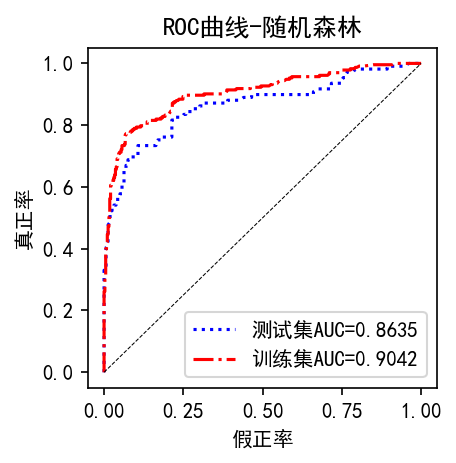

In [18]:
model4,fpr[3],tpr[3],auc[3] = model_fun(x2_train,y2_train,x2_test,y2_test,name='随机森林',params={'max_depth': 4},random_state=100,roc=True)
jiaocha_score[3] = jiaocha(model4,x2,y2) # 交叉验证 1次10折交叉验证
hxjz(model4,x2_train,y2_train,x2_test,y2_test,yuzhi=0.5)

### 决策树

{'criterion': 'gini', 'max_depth': 3, 'min_impurity_decrease': 0, 'min_samples_leaf': 1}
0.8628900489488724


实际为0   实际为1   预测准确率 违约企业预测准确率
1   2                                   
训练集 预测为0  352.0   62.0  83.95%    73.39%
    预测为1   38.0  171.0  83.95%    73.39%
测试集 预测为0  141.0   34.0  80.60%    68.81%
    预测为1   18.0   75.0  80.60%    68.81%

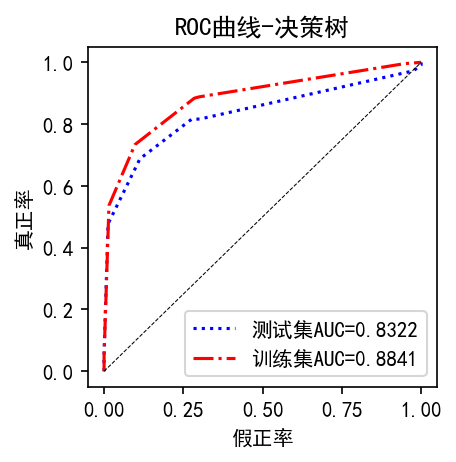

In [19]:
model5,fpr[4],tpr[4],auc[4] = model_fun(x2_train,y2_train,x2_test,y2_test,name='决策树',params=True,roc=True)
jiaocha_score[4] = jiaocha(model5,x2,y2) # 交叉验证 1次10折交叉验证
hxjz(model5,x2_train,y2_train,x2_test,y2_test,yuzhi=0.5)

### 朴素贝叶斯

0.826030331324449


实际为0   实际为1   预测准确率 违约企业预测准确率
1   2                                   
训练集 预测为0  336.0   71.0  79.94%    69.53%
    预测为1   54.0  162.0  79.94%    69.53%
测试集 预测为0  137.0   32.0  79.85%    70.64%
    预测为1   22.0   77.0  79.85%    70.64%

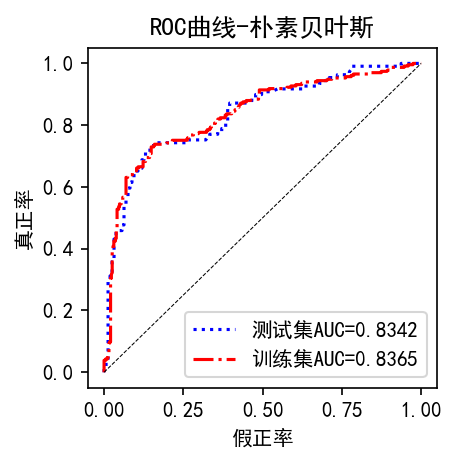

In [20]:
model5,fpr[5],tpr[5],auc[5] = model_fun(x2_train,y2_train,x2_test,y2_test,name='朴素贝叶斯',roc=True)
jiaocha_score[5] = jiaocha(model5,x2,y2) # 交叉验证 1次10折交叉验证jiaocha(model5,x2,y2,1) # 交叉验证 1次10折交叉验证
hxjz(model5,x2_train,y2_train,x2_test,y2_test,yuzhi=0.5)

### 各模型ROC曲线比较

Text(0.5, 1.0, '不同模型的ROC曲线')

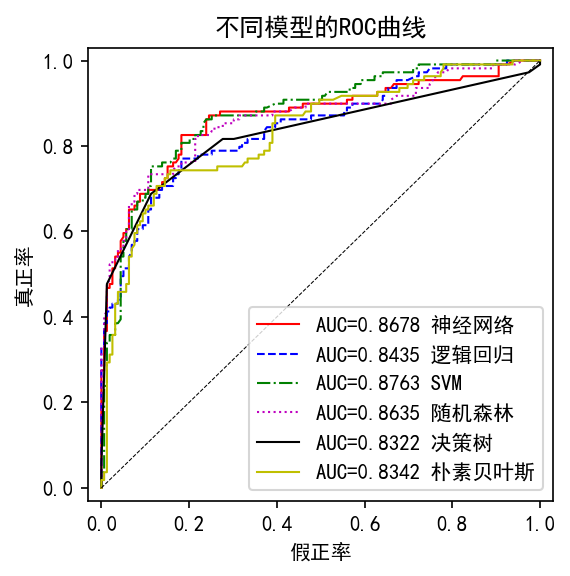

In [21]:
# 不同模型的ROC曲线
lable_names = ["神经网络","逻辑回归","SVM","随机森林","决策树","朴素贝叶斯"] # 模型名称
colors = ["r","b","g","m","k","y"] # 不同曲线颜色
linestyles =["-", "--", "-.", ":", "-","-"] #不同曲线

fig  = plt.figure(figsize=(4,4),dpi=150)
for n in range(6):
    ## 计算绘制ROC曲线的取值
        plt.plot(fpr[n], tpr[n],color=colors[n],linewidth = 1,
                 linestyle = linestyles[n],
                 label = f'AUC={auc[n]} '+lable_names[n])
plt.plot([0, 1], [0, 1], 'k--',linewidth = 0.5)
plt.xlabel("假正率"); plt.ylabel("真正率")
plt.xlim(-0.03, 1.03); plt.ylim(-0.03, 1.03)
# plt.grid()
plt.legend()
plt.title("不同模型的ROC曲线")

Text(0, 0.5, 'AUC')

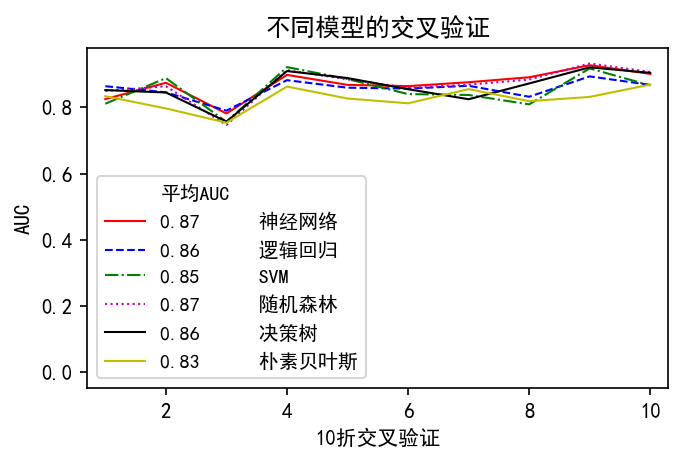

In [22]:
# 不同模型的交叉验证
x = jiaocha_score
plt.figure(dpi=150,figsize=(5,3))
lable_names = ["神经网络","逻辑回归","SVM","随机森林","决策树","朴素贝叶斯"] # 模型名称
colors = ["r","b","g","m","k","y"] # 不同曲线颜色
linestyles =["-", "--", "-.", ":", "-","-"] #不同曲线
plt.plot(0,0,'w.',label='平均AUC')
for n in range(6):
    mean = format(np.mean(x[n]),'.2f')
    plt.plot(range(1,11),x[n],color=colors[n],linewidth = 1,
                 linestyle = linestyles[n],
                 label = f'{mean}      '+lable_names[n])
plt.legend(fontsize=9.5,loc='best')
plt.xlim([0.7,10.3])
plt.title('不同模型的交叉验证')
plt.xlabel('10折交叉验证')
plt.ylabel('AUC')

## 选择神经网络---model1

缺失年龄填充

In [23]:
test = age_fillna(test)

各个缺失名称的平均年龄：
Mr : 32.25215146299484
Miss : 21.774238095238097
Mrs : 36.99411764705882
Master : 5.482641509433963
Ms : 28.0


缺失票价填充

In [24]:
def Fare_fillna(df): # 缺失票价填充函数
    df_all = pd.concat([train,test])
    index = df[df.Fare.isna()].Pclass.value_counts().index
    print('各个船舱缺失的评价船票价格:')
    for i in index:
        if len(df[df.Fare.isna()][df.Pclass==i]) == 0:
            raise Exception(i,'等舱没有样本填充')
        mean = df_all[df_all.Pclass==i].Fare.agg(np.mean)
        df.loc[df.Pclass==i,'Fare'] = df.loc[df.Pclass==i,'Fare'].fillna(mean)
        print(i,':',mean)

In [25]:
Fare_fillna(test)

各个船舱缺失的评价船票价格:
3 : 13.302888700564969


数据准备

In [26]:
x3 = test[['SibSp','Parch','Age','Fare','Pclass','Sex','Embarked']]
x3 = pd.get_dummies(x3,columns=['Pclass','Sex','Embarked'],drop_first=True)
# 标准化
columns=['SibSp','Parch','Age','Fare']
s1=StandardScaler()
s1.fit(x3.loc[:,columns])
x3.loc[:,columns] = s1.transform(x3.loc[:,columns])
x3 = x3[x2_train.columns]

In [27]:
test.loc[:,'Survived'] = model1.predict(x3)

In [29]:
test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_name,Survived
0,892,3,"Kelly, Mr. James",male,34.500000,0,0,330911,7.8292,NaN,Q,Mr,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.000000,1,0,363272,7.0000,NaN,S,Mrs,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.000000,0,0,240276,9.6875,NaN,Q,Mr,0
3,895,3,"Wirz, Mr. Albert",male,27.000000,0,0,315154,8.6625,NaN,S,Mr,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.000000,1,1,3101298,12.2875,NaN,S,Mrs,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,32.252151,0,0,A.5. 3236,8.0500,NaN,S,Mr,0
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.000000,0,0,PC 17758,108.9000,C105,C,Dona,1
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.500000,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,Mr,0
416,1308,3,"Ware, Mr. Frederick",male,32.252151,0,0,359309,8.0500,NaN,S,Mr,0


In [28]:
test[['PassengerId','Survived']].to_csv('submission.csv',index=False) # 保存到csv